<a href="https://colab.research.google.com/github/sant1dom/AI-Exam/blob/master/CodeCommentClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os
import nltk
nltk.download('stopwords')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)



Running on TPU  grpc://10.74.141.34:8470
Number of replicas: 8


In [22]:
train_file_path = r"https://raw.githubusercontent.com/micheleintrevado/ML4MDE/main/archive/train.csv"
train_set = pd.read_csv(train_file_path)
train_set.drop(columns=['ID'], inplace=True)
train_set.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Joining the title and abstract into a single text column

In [38]:
train_set["text"] = train_set["TITLE"] + " " + train_set["ABSTRACT"]
train_set.drop(columns=["TITLE", "ABSTRACT"], inplace=True)

# Dataset Analysis

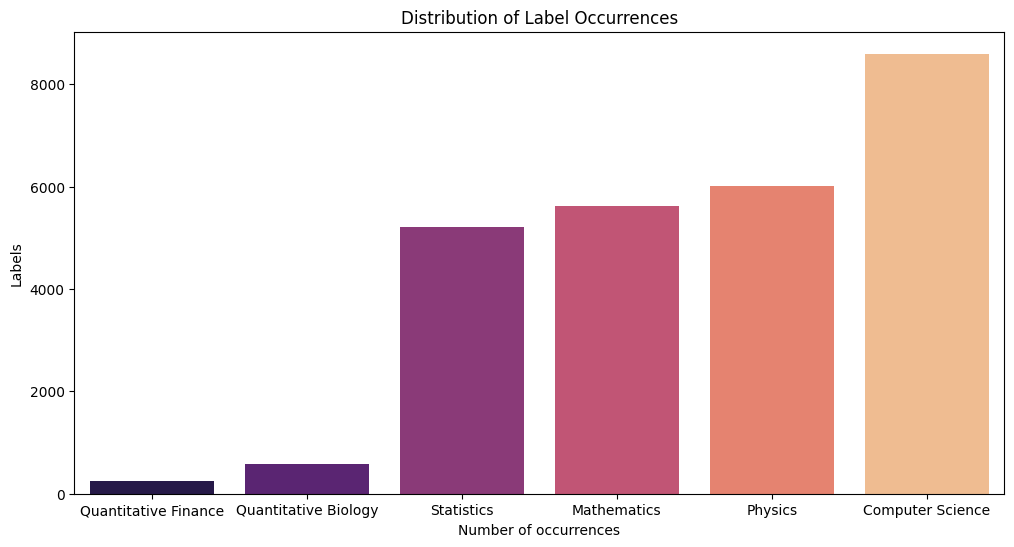

The exact values for each class are:


Quantitative Finance     249
Quantitative Biology     587
Statistics              5206
Mathematics             5618
Physics                 6013
Computer Science        8594
dtype: int64

In [34]:
# Count the occurencies of each labels.
labels = train_set.columns.tolist()[2:]
counts = train_set[labels].sum().sort_values()

# Creating an horizontal bar graph.
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=counts.index, y=counts.values, palette='magma')

# Adding labels and title to the graph.
plt.xlabel('Number of occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show graph
plt.show()
print(f"The exact values for each class are:")
train_set[labels].sum().sort_values()

# Prova model

In [41]:
contractions_dict = {
    "don't": "do not",
    "doesn't": "does not",
    "can't": "cannot",
    "isn't": "is not",
    "won't": "will not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "I won't": "I will not",
    "you won't": "you will not",
    "he won't": "he will not",
    "she won't": "she will not",
    "we won't": "we will not",
    "they won't": "they will not",
}

In [42]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [96]:
def prepare_text(text: str):
    text = text.lower()
    text = text.replace('"', '')
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join([contractions_dict.get(word, word) for word in text.split()])
    words = [word for word in text.split() if word not in stop_words and len(word) > 1]
    return " ".join(words).strip()

In [44]:
train_set['text'] = train_set['text'].apply(prepare_text)
train_set

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,0,0,0,0,0,reconstructing subject specific effect maps pr...
1,1,0,0,0,0,0,rotation invariance neural network rotation in...
2,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...
3,0,0,1,0,0,0,finite element approximation stochastic maxwel...
4,1,0,0,1,0,0,comparative study discrete wavelet transforms ...
...,...,...,...,...,...,...,...
20967,1,1,0,0,0,0,contemporary machine learning guide practition...
20968,0,1,0,0,0,0,uniform diamond coatings wc co hard alloy cutt...
20969,1,0,0,0,0,0,analysing soccer games clustering conceptors p...
20970,0,0,1,1,0,0,efficient simulation left tail sum correlated ...


In [78]:
X_data = train_set[['text']].values
y_data = train_set.iloc[:, 0:-1].values
print(f"len X_data: {len(X_data)}, len y_data: {len(y_data)}")

len X_data: 20972, len y_data: 20972


In [86]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding, Bidirectional, LSTM
from keras.models import Sequential
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold
import pickle
from keras.layers import TextVectorization
from keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, accuracy_score, confusion_matrix

In [102]:
# Step 1: Convert the array to a pandas Series
series_of_strings = pd.Series(X_data.flatten())

# Step 2: Split each string into a list of words
words_lists = series_of_strings.str.split()

# Step 3: Explode the lists into separate rows
exploded_series = words_lists.explode()

# Step 4: Calculate the number of unique words for each row
unique_word_counts = exploded_series.nunique()


print(f"The number of unique words is: {unique_word_counts}")

The maximum number of unique words is: 50762


In [103]:
# Text Vectorization
MAX_FEATURES = unique_word_counts
MAX_SEQUENCE = 200
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=MAX_SEQUENCE, output_mode='int')
vectorizer.adapt(X_data)

pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("tv_layer.pkl", "wb"))

X = np.array(vectorizer(X_data))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=10)

Evaluate model

In [104]:
# Build the Neural Network.
NUM_EPOCHS = 10
BATCH_SIZE = 16

model = Sequential()

model.add(Embedding(MAX_FEATURES + 1, 32))

model.add(Bidirectional(LSTM(32, activation="tanh")))

model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))

model.add(Dense(6, activation="sigmoid"))

model.compile(loss="BinaryCrossentropy", metrics=["accuracy"], optimizer="Adam")

In [105]:
# K-FOLD CROSS VALIDATION
NUM_FOLDS = 5
KF = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42) # K-Fold splitter

print("K Cross Fold Validation START")
index = 1
for train_index, val_index in KF.split(X_train):
  print(f"Fold {index}")

  # Split the data into training and validation sets for the current fold
  X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
  y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

  # Train the model on the current fold
  model.fit(X_fold_train, y_fold_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_fold_val, y_fold_val))

  # Evaluate the model on the validation set of the current fold
  scores = model.evaluate(X_fold_val, y_fold_val)

  print(f"Fold {index} => Loss: {scores[0]:.2f} and Accuracy: {scores[1]*100:.2f}%")
  index += 1

print("K Cross Fold Validation END")



K Cross Fold Validation START
Fold 1
Epoch 1/10
839/839 [==============================] - 59s 64ms/step - loss: 0.3133 - accuracy: 0.6792 - val_loss: 0.2411 - val_accuracy: 0.7867
Epoch 2/10
839/839 [==============================] - 51s 61ms/step - loss: 0.2022 - accuracy: 0.7780 - val_loss: 0.2232 - val_accuracy: 0.7455
Epoch 3/10
839/839 [==============================] - 51s 61ms/step - loss: 0.1537 - accuracy: 0.7914 - val_loss: 0.2329 - val_accuracy: 0.7214
Epoch 4/10
839/839 [==============================] - 51s 61ms/step - loss: 0.1174 - accuracy: 0.8106 - val_loss: 0.2560 - val_accuracy: 0.7098
Epoch 5/10
839/839 [==============================] - 51s 60ms/step - loss: 0.0913 - accuracy: 0.8230 - val_loss: 0.2775 - val_accuracy: 0.7119
Epoch 6/10
839/839 [==============================] - 51s 60ms/step - loss: 0.0696 - accuracy: 0.8343 - val_loss: 0.3379 - val_accuracy: 0.6999
Epoch 7/10
839/839 [==============================] - 54s 64ms/step - loss: 0.0550 - accuracy: 0.84

In [107]:
# Train the model with the entire dataset.
model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

# Display a summary of the model architecture and parameters
model.summary()

Epoch 1/10
1049/1049 [==============================] - 61s 58ms/step - loss: 0.0057 - accuracy: 0.8548
Epoch 2/10
1049/1049 [==============================] - 61s 58ms/step - loss: 0.0021 - accuracy: 0.8733
Epoch 3/10
1049/1049 [==============================] - 60s 57ms/step - loss: 5.8763e-04 - accuracy: 0.8628
Epoch 4/10
1049/1049 [==============================] - 60s 57ms/step - loss: 0.0013 - accuracy: 0.8724
Epoch 5/10
1049/1049 [==============================] - 60s 58ms/step - loss: 0.0023 - accuracy: 0.8499
Epoch 6/10
1049/1049 [==============================] - 60s 57ms/step - loss: 0.0023 - accuracy: 0.8490
Epoch 7/10
1049/1049 [==============================] - 60s 58ms/step - loss: 0.0015 - accuracy: 0.8720
Epoch 8/10
1049/1049 [==============================] - 60s 57ms/step - loss: 0.0013 - accuracy: 0.8552
Epoch 9/10
1049/1049 [==============================] - 60s 57ms/step - loss: 9.8866e-04 - accuracy: 0.8628
Epoch 10/10
1049/1049 [==============================] -

In [108]:
# Calculate metrics (Precision, Recall, Accuracy)
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

y_predicted = model.predict(X_test)
y_predicted = (y_predicted > 0.5).astype(int)

# Calculate metrics.
precision.update_state(y_test, y_predicted)
precision_value = precision.result().numpy()
recall.update_state(y_test, y_predicted)
recall_value = recall.result().numpy()
accuracy.update_state(y_test, y_predicted)
accuracy_value = accuracy.result().numpy()
hamming_loss_value = hamming_loss(y_test, y_predicted)
f1_value = (2 * precision_value * recall_value) / (precision_value + recall_value)

print(f"Precision: {precision_value:.2f}")
print(f"Recall:{recall_value:.2f}")
print(f"Accuracy:{accuracy_value:.2f}")
print(f"Hamming Loss: {hamming_loss_value:.2f}")
print(f"F-1 Score: {f1_value:.2f}")

132/132 [==============================] - 3s 15ms/step
Precision: 0.74
Recall:0.78
Accuracy:0.75
Hamming Loss: 0.10
F-1 Score: 0.76


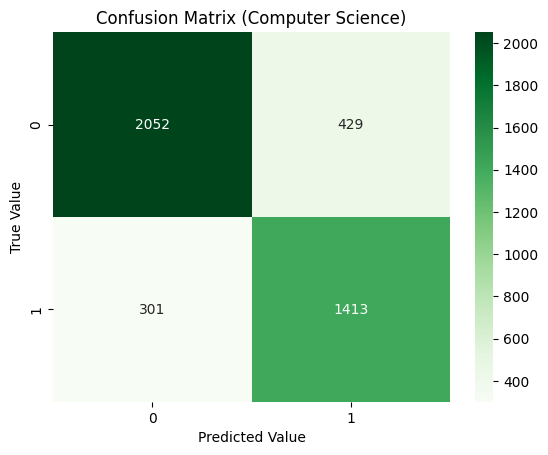

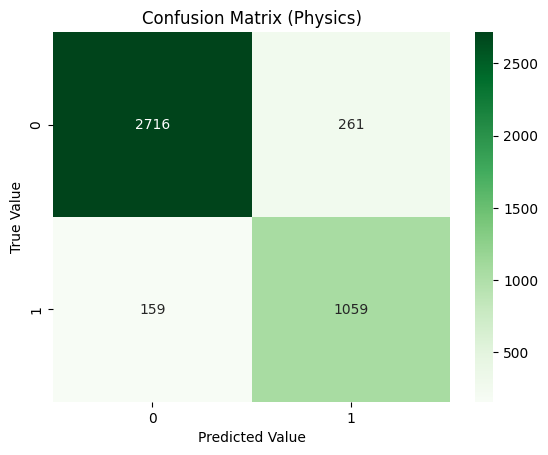

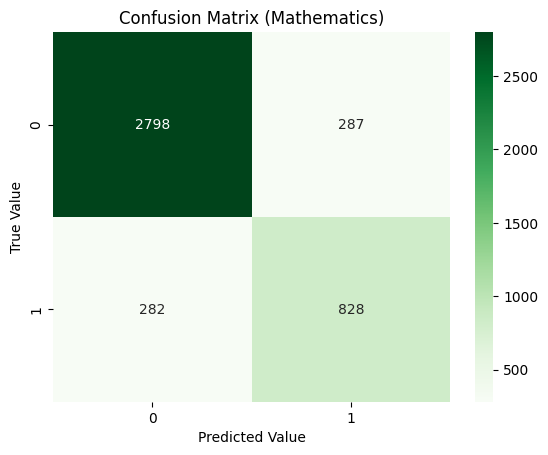

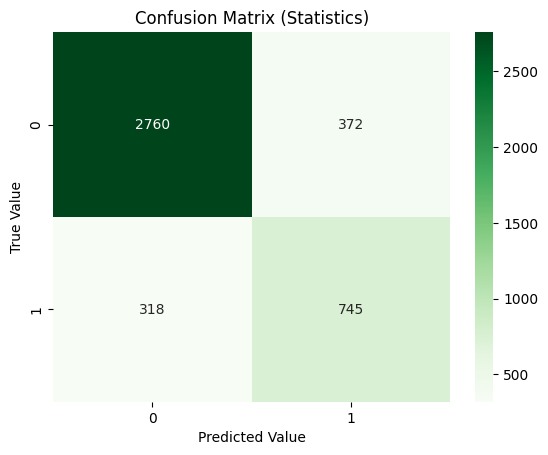

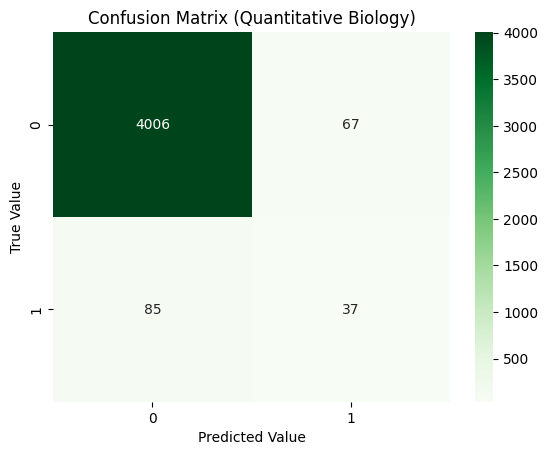

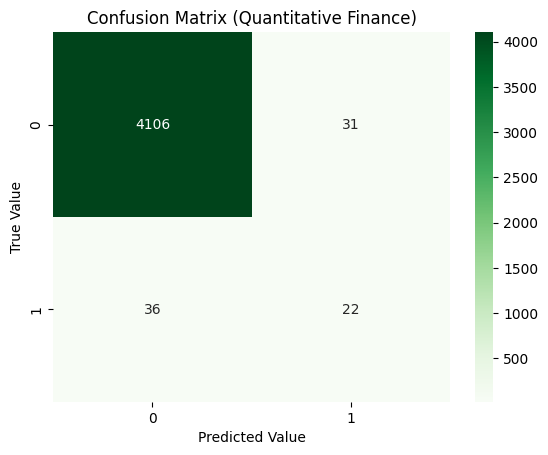

In [109]:
# List of labels corresponding to each toxicity category
labels = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]

for label in range(6):
  # Extract the true labels and predicted labels for the specific toxicity category
  y_test_i = [row[label] for row in y_test]
  y_predicted_i = [row[label] for row in y_predicted]

  # Creating confusion matrix.
  CM = confusion_matrix(y_test_i, y_predicted_i)

  # Showing confusion matrix as a heatmap.
  sns.heatmap(CM, annot=True, fmt="d", cmap="Greens")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")
  plt.title(f"Confusion Matrix ({labels[label]})")
  plt.show()

In [110]:
model.save('paper_classification.keras')

In [111]:
# Load the trained model
checkpoint = tf.keras.models.load_model("paper_classification.keras")

# Load the configuration and weights of the TextVectorization layer from the pickle file
from_disk = pickle.load(open("tv_layer.pkl", "rb"))

# Create a new TextVectorization layer using the loaded configuration
new_v = TextVectorization.from_config(from_disk['config'])

# Call `adapt` with some dummy data to set up the state of the TextVectorization layer
new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))

# Set the weights of the new TextVectorization layer to the loaded weights
new_v.set_weights(from_disk['weights'])


def pretty_prediction(title: str, abstract: str):
  text = title + abstract
  prepare_text(text)
  vectorized = new_v([text])

  # Make a prediction using the loaded model
  predicted = checkpoint.predict(vectorized)

  result = "Paper has been classified as: "
  labels_strings = []

  for index, label in enumerate(labels):
    if predicted[0][index] > 0.5:
      labels_strings.append(label)

  return result + ", ".join(labels_strings)

In [118]:
import requests
from bs4 import BeautifulSoup

def extract_title_and_abstract(ieee_link):
    # Make a request to the IEEE link
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    response = requests.get(ieee_link, headers=headers)

    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        print(soup)

        # Extract title
        title_element = soup.select_one('.document-title')
        title = title_element.text.strip() if title_element else None

        # Extract abstract
        abstract_element = soup.select_one('.abstract-text')
        abstract = abstract_element.text.strip() if abstract_element else None

        return title, abstract
    else:
        print(f"Failed to retrieve content. Status code: {response.status_code}")
        return None, None

while True:
  ieee_link = input("Insert the link of the paper from IEEE (type stop to block the execution): ")
  if ieee_link == "stop":
    break
  title, abstract = extract_title_and_abstract(ieee_link)
  if title and abstract:
      print("Title:", title)
      print("Abstract:", abstract)
      print(pretty_prediction(title, abstract))
  else:
      print("Error extracting title and abstract.")


Insert the link of the paper from IEEE (type stop to block the execution): https://ieeexplore.ieee.org/document/8589380
<!DOCTYPE html>

<apm_do_not_touch>
<script type="text/javascript">
(function(){
window.qzj=!!window.qzj;try{(function(){(function(){var J={decrypt:function(J){try{return JSON.parse(function(J){J=J.split("l");var L="";for(var z=0;z<J.length;++z)L+=String.fromCharCode(J[z]);return L}(J))}catch(z){}}};return J={configuration:J.decrypt("123l34l97l99l116l105l118l101l34l58l34l110l111l34l44l34l100l101l98l117l103l103l105l110l103l34l58l34l110l111l34l44l34l109l111l100l117l108l101l49l34l58l34l101l110l97l98l108l101l100l34l44l34l109l111l100l117l108l101l50l34l58l34l101l110l97l98l108l101l100l34l44l34l109l111l100l117l108l101l51l34l58l34l101l110l97l98l108l101l100l34l44l34l109l111l100l117l108l101l52l34l58l34l101l110l97l98l108l101l100l34l125")}})();
var LJ=1;try{var oJ,ZJ,SJ=l(272)?1:0,IJ=l(113)?1:0,Jl=l(266)?1:0,ol=l(308)?1:0;for(var Ol=(l(826),0);Ol<ZJ;++Ol)SJ+=l(145)?2:1,IJ+=l(479)?

KeyboardInterrupt: Interrupted by user